<a href="https://colab.research.google.com/github/efrat-dev/ai-code-notebooks/blob/main/03_xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import numpy as np
import pandas as pd
import random
import gdown
import xgboost as xgb
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve, average_precision_score,
    fbeta_score, precision_score, recall_score
)
import matplotlib.pyplot as plt
import seaborn as sns

# Seed

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Download and load files

In [3]:
file_ids = {
    'train': '12p0bNMpieaZ6yoPS-BI71QA_oz7t708i',
    'test':  '18r_G-VF2mjD3ZsGdKOLKFQ6lO5ptSZ_y',
    'val':   '1hShE7wkL0d9BE5AVdKgfV68adyCE_jy5',
    'lstm':  '1OeYY16SnH8w5YX7VbUvozO_ZYVFR8pRD',
    'forest':'1LVdDbjTDmGRYlQ7QO1zOmiKaQtOpvoWd'
}

def download_file(file_id, filename):
    url = f'https://drive.google.com/uc?id={file_id}'
    gdown.download(url, filename, quiet=False)

download_file(file_ids['train'], 'train_processed_lstm.csv')
download_file(file_ids['test'],  'test_processed_lstm.csv')
download_file(file_ids['val'],   'val_processed_lstm.csv')
download_file(file_ids['lstm'],  'lstm_scores_all_splits.csv')
download_file(file_ids['forest'],'if_score_per_employee.csv')

# Action files (action/day level) — each split separately
actions_train = pd.read_csv("train_processed_lstm.csv")
actions_test  = pd.read_csv("test_processed_lstm.csv")
actions_val   = pd.read_csv("val_processed_lstm.csv")

# Employee-level scores
df_lstm = pd.read_csv("lstm_scores_all_splits.csv")
try:
    df_iso = pd.read_csv("if_score_per_employee.csv")
except FileNotFoundError:
    df_iso = pd.DataFrame(columns=["employee_id", "if_employee_score"])

Downloading...
From (original): https://drive.google.com/uc?id=12p0bNMpieaZ6yoPS-BI71QA_oz7t708i
From (redirected): https://drive.google.com/uc?id=12p0bNMpieaZ6yoPS-BI71QA_oz7t708i&confirm=t&uuid=d5477188-85c0-4fc2-8cf3-61602a9da6dc
To: /content/train_processed_lstm.csv
100%|██████████| 396M/396M [00:05<00:00, 78.8MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=18r_G-VF2mjD3ZsGdKOLKFQ6lO5ptSZ_y
From (redirected): https://drive.google.com/uc?id=18r_G-VF2mjD3ZsGdKOLKFQ6lO5ptSZ_y&confirm=t&uuid=774818cd-39c5-43da-9565-3058c7baa6ec
To: /content/test_processed_lstm.csv
100%|██████████| 132M/132M [00:02<00:00, 62.2MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1hShE7wkL0d9BE5AVdKgfV68adyCE_jy5
From (redirected): https://drive.google.com/uc?id=1hShE7wkL0d9BE5AVdKgfV68adyCE_jy5&confirm=t&uuid=9d6cad36-f8e6-4454-99bf-ff91a4cceb7b
To: /content/val_processed_lstm.csv
100%|██████████| 132M/132M [00:02<00:00, 58.3MB/s]
Downloading...
From: https://drive.go

# Aggregation to employee level

In [4]:
# Aggregation to employee level (no set mixing)

THRESHOLD = 0.2  # "At least 20%" is considered malicious

static_cols = [
    'employee_id',
    'employee_seniority_years',
    'employee_department_freq',
    'employee_position_freq',
    'employee_campus_cat_Campus A',
    'employee_campus_cat_Campus B',
    'employee_campus_cat_Campus C',
    'is_contractor_binary',
    'employee_classification_freq',
    'has_foreign_citizenship_binary',
    'has_criminal_record_binary',
    'has_medical_history_binary',
    'is_new_employee_binary',
    'is_veteran_employee_binary'
]

def build_employee_level_df(actions_df):
    # Malicious action ratio per employee within the current split only
    employee_risk = actions_df.groupby('employee_id')['is_malicious'].mean().reset_index()
    employee_risk = employee_risk.rename(columns={'is_malicious': 'risk_ratio'})
    employee_risk['is_malicious'] = (employee_risk['risk_ratio'] >= THRESHOLD).astype(int)

    # Static columns — first row per employee
    df_static = actions_df[static_cols].drop_duplicates(subset='employee_id', keep='first')

    # Merges
    df_emp = pd.merge(df_static, employee_risk[['employee_id', 'is_malicious']], on='employee_id', how='inner')
    df_emp = pd.merge(df_emp, df_lstm[['employee_id', 'lstm_score']], on='employee_id', how='inner')
    df_emp = pd.merge(df_emp, df_iso[['employee_id', 'if_employee_score']], on='employee_id', how='left')
    if 'if_employee_score' not in df_emp.columns:
        df_emp['if_employee_score'] = -1
    else:
        df_emp['if_employee_score'] = df_emp['if_employee_score'].fillna(-1)

    employee_risk = employee_risk.drop(columns=['risk_ratio'])
    return df_emp

# Build employee-level data for each split separately (no re-split)
train_df = build_employee_level_df(actions_train)
val_df   = build_employee_level_df(actions_val)
test_df  = build_employee_level_df(actions_test)

# Save to files
train_df.to_csv("xgboost_train.csv", index=False)
val_df.to_csv("xgboost_val.csv", index=False)
test_df.to_csv("xgboost_test.csv", index=False)
print(" SAVED xgboost_train.csv / xgboost_val.csv / xgboost_test.csv")

 SAVED xgboost_train.csv / xgboost_val.csv / xgboost_test.csv


# Train XGBoost

## Simple XGBoost Model (V1)

In [13]:
# Simple XGBoost Baseline (No Optimization)
import xgboost as xgb
import numpy as np
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, fbeta_score
import pandas as pd

print("=== SIMPLE XGBOOST BASELINE (NO OPTIMIZATION) ===\n")

X_train = train_df.drop(columns=['employee_id', 'is_malicious'])
y_train = train_df['is_malicious']
X_val   = val_df.drop(columns=['employee_id', 'is_malicious'])
y_val   = val_df['is_malicious']
X_test  = test_df.drop(columns=['employee_id', 'is_malicious'])
y_test  = test_df['is_malicious']

dtrain_simple = xgb.DMatrix(X_train, label=y_train)
dval_simple   = xgb.DMatrix(X_val,   label=y_val)
dtest_simple  = xgb.DMatrix(X_test,  label=y_test)

simple_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'seed': 42
}

print("Training Simple XGBoost with default parameters. Parameters used:", simple_params)

simple_booster = xgb.train(
    simple_params,
    dtrain_simple,
    num_boost_round=100,
    evals=[(dtrain_simple, 'train'), (dval_simple, 'val')],
    verbose_eval=20
)

=== SIMPLE XGBOOST BASELINE (NO OPTIMIZATION) ===

Training Simple XGBoost with default parameters. Parameters used: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'seed': 42}
[0]	train-logloss:0.10509	val-logloss:0.09019
[20]	train-logloss:0.01438	val-logloss:0.06465
[40]	train-logloss:0.00899	val-logloss:0.06504
[60]	train-logloss:0.00689	val-logloss:0.06706
[80]	train-logloss:0.00605	val-logloss:0.06829
[99]	train-logloss:0.00548	val-logloss:0.06923


## Improved XGBoost Model (V2)

In [5]:
# Train XGBoost with xgb.train + early stopping

X_train = train_df.drop(columns=['employee_id', 'is_malicious'])
y_train = train_df['is_malicious']
X_val   = val_df.drop(columns=['employee_id', 'is_malicious'])
y_val   = val_df['is_malicious']
X_test  = test_df.drop(columns=['employee_id', 'is_malicious'])
y_test  = test_df['is_malicious']

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X_train.columns.tolist())
dval   = xgb.DMatrix(X_val,   label=y_val,   feature_names=X_val.columns.tolist())
dtest  = xgb.DMatrix(X_test,  label=y_test,  feature_names=X_test.columns.tolist())

params = dict(
    objective='binary:logistic',
    eval_metric='logloss',
    max_depth=4,
    eta=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    seed=SEED
)

booster = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=[(dtrain, 'train'), (dval, 'eval')],
    early_stopping_rounds=10,
    verbose_eval=True
)

best_iter = getattr(booster, "best_iteration", None)

[0]	train-logloss:0.18729	eval-logloss:0.15688
[1]	train-logloss:0.15526	eval-logloss:0.12887
[2]	train-logloss:0.13777	eval-logloss:0.11432
[3]	train-logloss:0.12929	eval-logloss:0.11006
[4]	train-logloss:0.11742	eval-logloss:0.09993
[5]	train-logloss:0.10702	eval-logloss:0.09207
[6]	train-logloss:0.09932	eval-logloss:0.08567
[7]	train-logloss:0.09471	eval-logloss:0.08228
[8]	train-logloss:0.08820	eval-logloss:0.07727
[9]	train-logloss:0.08274	eval-logloss:0.07352
[10]	train-logloss:0.07967	eval-logloss:0.07190
[11]	train-logloss:0.07524	eval-logloss:0.06858
[12]	train-logloss:0.07075	eval-logloss:0.06504
[13]	train-logloss:0.06711	eval-logloss:0.06264
[14]	train-logloss:0.06383	eval-logloss:0.06028
[15]	train-logloss:0.06204	eval-logloss:0.05997
[16]	train-logloss:0.05964	eval-logloss:0.05802
[17]	train-logloss:0.05689	eval-logloss:0.05755
[18]	train-logloss:0.05470	eval-logloss:0.05683
[19]	train-logloss:0.05258	eval-logloss:0.05639
[20]	train-logloss:0.05036	eval-logloss:0.05572
[2

# prediction

## Simple XGBoost Model (V1)

In [22]:
y_val_proba_simple = simple_booster.predict(dval_simple)
y_test_proba_simple = simple_booster.predict(dtest_simple)

## Improved XGBoost Model (V2)

In [6]:
# Version-compatible prediction: try iteration_range first; if unsupported — regular predict
def predict_best(bst, dmat):
    try:
        if best_iter is not None:
            return bst.predict(dmat, iteration_range=(0, best_iter + 1))
        return bst.predict(dmat)
    except TypeError:
        return bst.predict(dmat)

y_val_proba  = predict_best(booster, dval)
y_test_proba = predict_best(booster, dtest)

# threshold selection

## Simple XGBoost Model (V1)

In [15]:
threshold_simple = 0.5
y_val_pred_simple = (y_val_proba_simple >= threshold_simple).astype(int)
y_test_pred_simple = (y_test_proba_simple >= threshold_simple).astype(int)

## Improved XGBoost Model (V2)

In [23]:
# Generic threshold selection: max F1 with preference for 0.5

def choose_threshold_max_f1(y_true, y_score, grid=1001, tol=1e-4, prefer_05=True):
    """
    Selects a threshold that maximizes F1 on the validation set.
    If prefer_05=True – choose t=0.5 when F1@0.5 is within tol of the maximum.
    Otherwise: among the max-F1 candidates, pick the one with minimal |P-R|, then closest to 0.5.
    """
    thresholds = np.linspace(0, 1, grid)
    rows = []
    for t in thresholds:
        y_pred = (y_score >= t).astype(int)
        p = precision_score(y_true, y_pred, zero_division=0)
        r = recall_score(y_true, y_pred, zero_division=0)
        f1 = fbeta_score(y_true, y_pred, beta=1.0, zero_division=0)
        rows.append((t, p, r, f1, abs(p - r), abs(t - 0.5)))
    df = pd.DataFrame(rows, columns=['threshold','precision','recall','f1','balance_gap','dist_from_0_5'])

    f1_max = df['f1'].max()

    # Prefer 0.5 if it's good enough
    if prefer_05:
        y05 = (y_score >= 0.5).astype(int)
        p05 = precision_score(y_true, y05, zero_division=0)
        r05 = recall_score(y_true, y05, zero_division=0)
        f105 = fbeta_score(y_true, y05, beta=1.0, zero_division=0)
        if f105 >= f1_max - tol:
            df_sorted = df.sort_values(by=['f1','balance_gap','dist_from_0_5'], ascending=[False, True, True])
            return 0.5, df_sorted

    # If 0.5 doesn't meet the condition — choose the "winner" with tie-breakers
    top = df[np.isclose(df['f1'], f1_max, atol=tol)].copy()
    top = top.sort_values(by=['balance_gap','dist_from_0_5'], ascending=[True, True])
    t_star = float(top.iloc[0]['threshold'])
    df_sorted = df.sort_values(by=['f1','balance_gap','dist_from_0_5'], ascending=[False, True, True])
    return t_star, df_sorted

opt_t, f1_table = choose_threshold_max_f1(y_val, y_val_proba, grid=1001, tol=1e-4, prefer_05=True)
print(f"\n★ Threshold selected on VALIDATION by max F1 (prefers 0.5): {opt_t:.3f}")
print("Top F1 candidates:\n", f1_table.head(10))


★ Threshold selected on VALIDATION by max F1 (prefers 0.5): 0.426
Top F1 candidates:
      threshold  precision    recall   f1  balance_gap  dist_from_0_5
426      0.426   0.705882  0.923077  0.8     0.217195          0.074
425      0.425   0.705882  0.923077  0.8     0.217195          0.075
424      0.424   0.705882  0.923077  0.8     0.217195          0.076
423      0.423   0.705882  0.923077  0.8     0.217195          0.077
422      0.422   0.705882  0.923077  0.8     0.217195          0.078
421      0.421   0.705882  0.923077  0.8     0.217195          0.079
420      0.420   0.705882  0.923077  0.8     0.217195          0.080
419      0.419   0.705882  0.923077  0.8     0.217195          0.081
418      0.418   0.705882  0.923077  0.8     0.217195          0.082
417      0.417   0.705882  0.923077  0.8     0.217195          0.083


# Evaluation

## Simple baseline evaluation (V1)

In [24]:
print("\nVALIDATION SET RESULTS:")
val_report_simple = classification_report(y_val, y_val_pred_simple, digits=3, zero_division=0)
print(val_report_simple)

print("\nTEST SET RESULTS:")
test_report_simple = classification_report(y_test, y_test_pred_simple, digits=3, zero_division=0)
print(test_report_simple)


VALIDATION SET RESULTS:
              precision    recall  f1-score   support

           0      0.994     0.985     0.989       323
           1      0.688     0.846     0.759        13

    accuracy                          0.979       336
   macro avg      0.841     0.915     0.874       336
weighted avg      0.982     0.979     0.980       336


TEST SET RESULTS:
              precision    recall  f1-score   support

           0      0.997     0.994     0.995       318
           1      0.889     0.941     0.914        17

    accuracy                          0.991       335
   macro avg      0.943     0.967     0.955       335
weighted avg      0.991     0.991     0.991       335



## Improved evaluation (V2)

In [26]:
# Predictions & reports at the optimal threshold (same threshold for test)
y_val_pred_opt  = (y_val_proba  >= opt_t).astype(int)
y_test_pred_opt = (y_test_proba >= opt_t).astype(int)

print("\nValidation Report @ selected threshold:")
print(classification_report(y_val, y_val_pred_opt, digits=2, zero_division=0))
print("\nTest Report @ selected threshold:")
print(classification_report(y_test, y_test_pred_opt, digits=2, zero_division=0))


Validation Report @ selected threshold:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       323
           1       0.71      0.92      0.80        13

    accuracy                           0.98       336
   macro avg       0.85      0.95      0.90       336
weighted avg       0.99      0.98      0.98       336


Test Report @ selected threshold:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       318
           1       0.89      1.00      0.94        17

    accuracy                           0.99       335
   macro avg       0.95      1.00      0.97       335
weighted avg       0.99      0.99      0.99       335



# ROC, PR, confusion matrices & feature importance

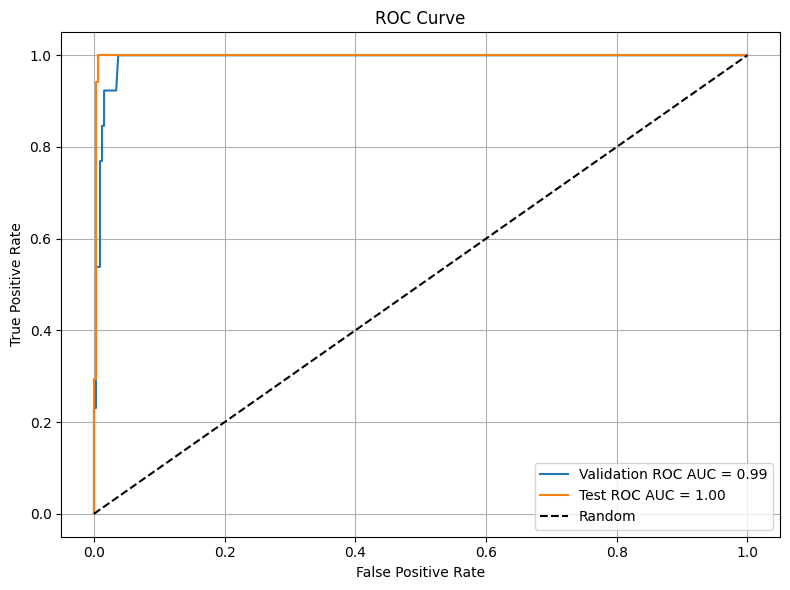

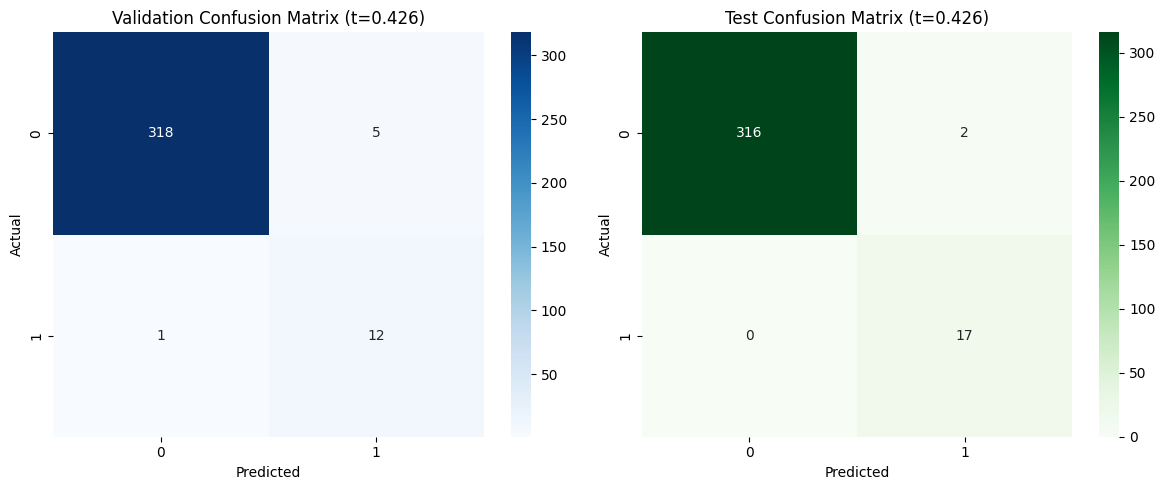


Feature Importance:
                           feature  importance
13                      lstm_score   13.223083
14               if_employee_score    3.630854
1         employee_department_freq    3.108964
4     employee_campus_cat_Campus B    1.514532
2           employee_position_freq    1.382900
7     employee_classification_freq    1.079017
0         employee_seniority_years    0.979791
5     employee_campus_cat_Campus C    0.898142
12      is_veteran_employee_binary    0.255581
3     employee_campus_cat_Campus A    0.140301
6             is_contractor_binary    0.000000
10      has_medical_history_binary    0.000000
9       has_criminal_record_binary    0.000000
8   has_foreign_citizenship_binary    0.000000
11          is_new_employee_binary    0.000000


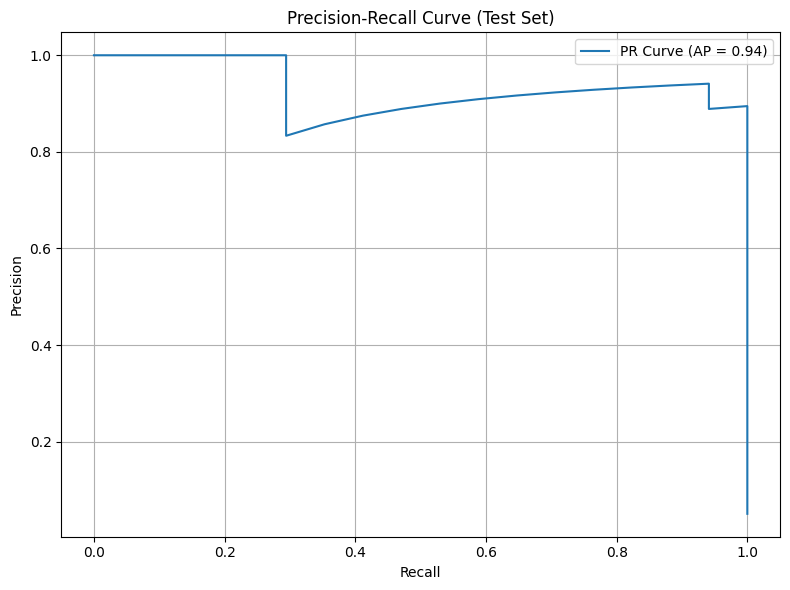


Performance on Test Set at Different Fixed Thresholds (for reference):

Threshold = 0.2
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       318
           1       0.81      1.00      0.89        17

    accuracy                           0.99       335
   macro avg       0.90      0.99      0.94       335
weighted avg       0.99      0.99      0.99       335


Threshold = 0.3
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       318
           1       0.89      1.00      0.94        17

    accuracy                           0.99       335
   macro avg       0.95      1.00      0.97       335
weighted avg       0.99      0.99      0.99       335


Threshold = 0.4
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       318
           1       0.89      1.00      0.94        17

    accuracy                           0.99       335
   ma

In [9]:
# ROC, PR, confusion matrices & feature importance (for illustration)
val_conf = confusion_matrix(y_val, y_val_pred_opt)
test_conf = confusion_matrix(y_test, y_test_pred_opt)

val_auc = roc_auc_score(y_val, y_val_proba)
test_auc = roc_auc_score(y_test, y_test_proba)

fpr_val, tpr_val, _ = roc_curve(y_val, y_val_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr_val, tpr_val, label=f'Validation ROC AUC = {val_auc:.2f}')
plt.plot(fpr_test, tpr_test, label=f'Test ROC AUC = {test_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve'); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(val_conf, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title(f'Validation Confusion Matrix (t={opt_t:.3f})')
axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('Actual')
sns.heatmap(test_conf, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title(f'Test Confusion Matrix (t={opt_t:.3f})')
axes[1].set_xlabel('Predicted'); axes[1].set_ylabel('Actual')
plt.tight_layout(); plt.show()

# Feature importance by gain
scores = booster.get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': [scores.get(f, 0.0) for f in X_train.columns]
}).sort_values(by='importance', ascending=False)
print("\nFeature Importance:")
print(importance_df)

# Precision-Recall Curve (on test set)
precision, recall, thresholds = precision_recall_curve(y_test, y_test_proba)
ap_score = average_precision_score(y_test, y_test_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AP = {ap_score:.2f})')
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Test Set)')
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

# Optional: print comparison at several fixed thresholds (does not affect selection)
thresholds_to_check = [0.2, 0.3, 0.4, 0.5, 0.6]
print("\nPerformance on Test Set at Different Fixed Thresholds (for reference):")
for thresh in thresholds_to_check:
    preds = (y_test_proba >= thresh).astype(int)
    report = classification_report(y_test, preds, output_dict=False, zero_division=0)
    print(f"\nThreshold = {thresh}")
    print(report)
